In [ ]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 19), reused 39 (delta 12), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [ ]:
# !rm -rf /content/vision_pytorch/

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 6.6MB/s 
     |████████████████████████████████| 38.2MB 70kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# %cd /content/drive/MyDrive/EVA6/VisionRepo/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import custom_resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *
from vision_pytorch.lrfinder import *

In [ ]:
import vision_pytorch

In [ ]:
import importlib 
importlib.reload(vision_pytorch.models)
from vision_pytorch.models import custom_resnet

In [ ]:
importlib.reload(custom_resnet)

<module 'vision_pytorch.models.custom_resnet' from '/content/vision_pytorch/models/custom_resnet.py'>

In [ ]:
# importlib.reload(vision_pytorch.main)
# from vision_pytorch.main import *

In [ ]:
trainset, testset = download_data()


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


In [ ]:
plot_aug({
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, 
                               min_width=8, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Horizontal Flip': A.HorizontalFlip(always_apply=True)
}, data=trainset)

In [ ]:
train_transform = A.Compose(
    {
        
     A.Sequential([
                   A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by defaulf
                   A.RandomCrop(32,32)
                   ]),
     A.HorizontalFlip(),
     A.CoarseDropout(1, 8, 8, 1, 8, 8,fill_value=0.473363, mask_fill_value=None),
     A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
     }
     )

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32
    
print(f'Batch Size: {BATCH_SIZE}')

CUDA Available: True
Batch Size: 512


In [ ]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
net = custom_resnet.customResnet()
net = net.to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
       BasicBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
       BasicBlock-14            [-1, 25


Learning rate search finished. See the graph with {finder_name}.plot()


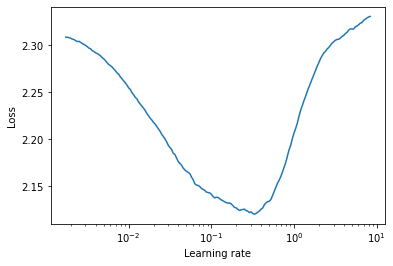

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2, steps_per_epoch=len(train_loader), 
#                                                  epochs=25, anneal_strategy='linear')

criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()  

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.3311311214825911


#Train the model

In [ ]:
ler_rate = 0.06

In [ ]:
net = custom_resnet.customResnet()
net = net.to(device)

In [ ]:

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.03631,
                                                # max_lr=0.05,
                                                steps_per_epoch=len(train_loader), 
                                                 epochs=24,pct_start=0.2, div_factor=10,  three_phase=False, verbose=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=10,
net, history = fit_model(
    net=net, device=device,
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1




Test set: Average loss: 2.1571, Accuracy: 4328/10000 (43.28%)

EPOCH: 2




Test set: Average loss: 2.0241, Accuracy: 5457/10000 (54.57%)

EPOCH: 3




Test set: Average loss: 1.9641, Accuracy: 6062/10000 (60.62%)

EPOCH: 4




Test set: Average loss: 1.9730, Accuracy: 5869/10000 (58.69%)

EPOCH: 5




Test set: Average loss: 1.8771, Accuracy: 6802/10000 (68.02%)

EPOCH: 6




Test set: Average loss: 1.8760, Accuracy: 6808/10000 (68.08%)

EPOCH: 7




Test set: Average loss: 1.9306, Accuracy: 6261/10000 (62.61%)

EPOCH: 8




Test set: Average loss: 1.8182, Accuracy: 7346/10000 (73.46%)

EPOCH: 9




Test set: Average loss: 1.7876, Accuracy: 7644/10000 (76.44%)

EPOCH: 10




Test set: Average loss: 1.7861, Accuracy: 7644/10000 (76.44%)

EPOCH: 11




Test set: Average loss: 1.7719, Accuracy: 7779/10000 (77.79%)

EPOCH: 12




Test set: Average loss: 1.7685, Accuracy: 7831/10000 (78.31%)

EPOCH: 13




Test set: Average loss: 1.7561, Accuracy: 7937/10000 (79.37%)

EPOCH: 14




Test set: Average loss: 1.7288, Accuracy: 8188/10000 (81.88%)

EPOCH: 15




Test set: Average loss: 1.7198, Accuracy: 8287/10000 (82.87%)

EPOCH: 16




Test set: Average loss: 1.7291, Accuracy: 8182/10000 (81.82%)

EPOCH: 17




Test set: Average loss: 1.7218, Accuracy: 8254/10000 (82.54%)

EPOCH: 18




Test set: Average loss: 1.7153, Accuracy: 8324/10000 (83.24%)

EPOCH: 19




Test set: Average loss: 1.7101, Accuracy: 8360/10000 (83.60%)

EPOCH: 20




Test set: Average loss: 1.7014, Accuracy: 8456/10000 (84.56%)

EPOCH: 21




Test set: Average loss: 1.6941, Accuracy: 8527/10000 (85.27%)

EPOCH: 22




Test set: Average loss: 1.6862, Accuracy: 8608/10000 (86.08%)

EPOCH: 23




Test set: Average loss: 1.6805, Accuracy: 8663/10000 (86.63%)

EPOCH: 24




Test set: Average loss: 1.6759, Accuracy: 8694/10000 (86.94%)



Collect the learning rate used for training and plot

In [ ]:
print("Range of the LR is {} -> {} -> {}".format(history[4][0], max(history[4]), history[4][-1])) 

Range of the LR is [0.003700618662121858] -> [0.036298444713010206] -> [5.3361188350337097e-05]


In [ ]:
len(history[3])


24

In [ ]:
len(history[4])

1176

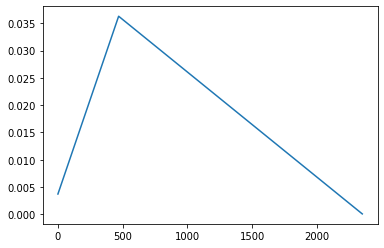

In [ ]:
plt.plot(history[4])

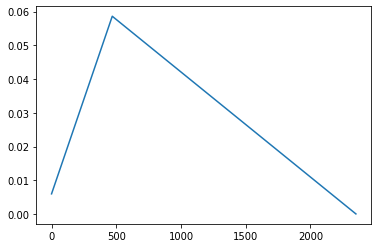

In [ ]:
lr_hist = history[4][0]
for i in range(1, len(history[4])):
    lr_hist.extend(history[4][i])
plt.plot(lr_hist)

In [ ]:
history_34 = history

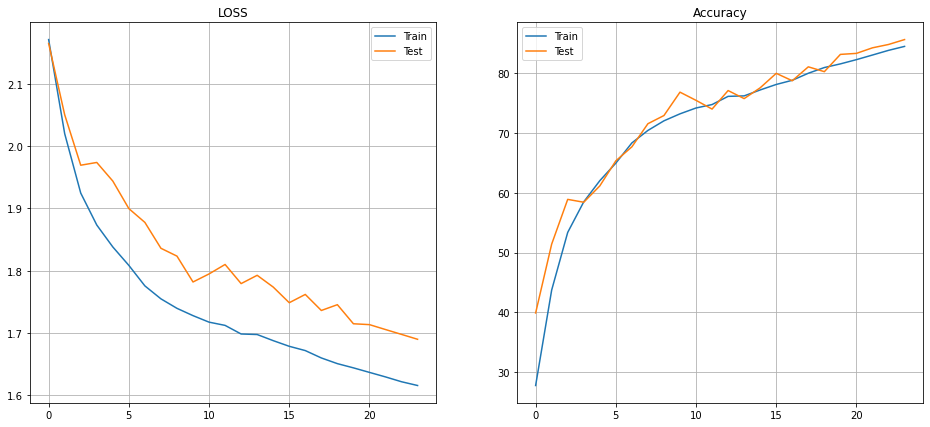

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history_34[1], label='Train')
axs[0].plot(history_34[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history_34[0], label='Train')
axs[1].plot(history_34[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [ ]:
net_18.load_state_dict(torch.load("resnet18.pt"))

In [ ]:
net_18.eval()
img,lab = test_loader.dataset[100]
img = img.unsqueeze(0).to(device)
pred = net_18(img)

In [ ]:
pred,lab

In [ ]:
pred.shape

In [ ]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
wrong_pred = plot_misclassified(net_18, test_loader, testset.classes, device, mean, std, return_misclf=True)

In [ ]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
wrong_pred = plot_misclassified(net_34, test_loader, testset.classes, device, mean, std, return_misclf=True)